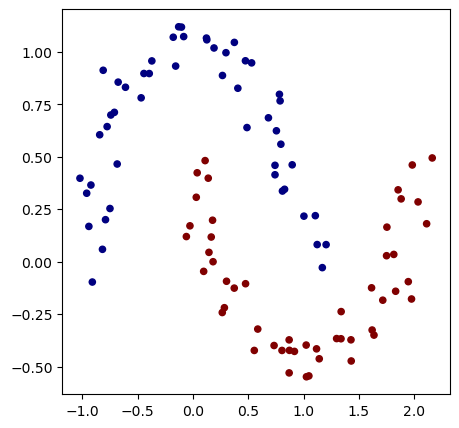

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List
import random
from shrimpgrad import Tensor, nn, dtypes
import ctypes
from shrimpgrad.util import dump_tensors

np.random.seed(1337)
random.seed(1337)

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.1)
X = X.astype(float)
y = y.astype(float)
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [2]:
X_train = Tensor.fromlist(X.shape, X.flatten().tolist())
y_train = Tensor.fromlist((100,1), y.flatten().tolist())
class ShallowNet:
    def __init__(self):
        self.layers: List[Callable[[Tensor], Tensor]] = [
         nn.Linear(2, 50), Tensor.relu,
         nn.Linear(50, 1), Tensor.sigmoid,
        ]
    def __call__(self, x: Tensor):
        return x.sequential(self.layers)

In [3]:
snet = ShallowNet()
sgd = nn.optim.SGD(nn.get_parameters(snet), lr=3.0)

from shrimpgrad.engine.jit import ShrimpJit

def optimize(model, opt, X, y, epochs=5, lr=0.01):
    @ShrimpJit
    def train(X,y):
      sgd.zero_grad()
      out = model(Tensor.fromlist(X.shape, X.flatten().tolist())).reshape(100)
      loss = out.binary_cross_entropy(Tensor.fromlist(y.shape, y.flatten().tolist()))
      loss.backward()
      sgd.step()
      return out, loss
    for epoch in range(epochs):
        out, loss = train(X,y)
        y_ = Tensor.fromlist(y.shape, y.flatten().tolist())
        target = (y_ > 0).realize().data()
        numerator = (target == (out.data() > 0.5)).sum()
        accuracy = (numerator / out.size(0)) * 100.0
        addr = ctypes.addressof(loss.thunk.base.buff._pointer(ctypes.c_float))
        print(f'epoch={epoch} loss={loss.data()} loss_addr=0x{addr:X} acc={accuracy}')

optimize(snet, sgd, X, y, 70)

[JIT_IGNORE]
epoch=0 loss=0.6840305328369141 loss_addr=0x169250218 acc=50.0
[JIT_CAPTURE]
[JIT_CAPTURE_KERNELS] capturing 24 kernels for CLANG with 0 changing inputs
[DONE JIT_CAPTURE_KERNELS]
epoch=1 loss=0.44467657804489136 loss_addr=0x1692C2A98 acc=79.0
[JIT_EXEC]
epoch=2 loss=0.436199426651001 loss_addr=0x1692C2A98 acc=81.0
[JIT_EXEC]
epoch=3 loss=0.3553045690059662 loss_addr=0x1692C2A98 acc=82.0
[JIT_EXEC]
epoch=4 loss=0.3413272202014923 loss_addr=0x1692C2A98 acc=84.0
[JIT_EXEC]
epoch=5 loss=0.32919129729270935 loss_addr=0x1692C2A98 acc=86.0
[JIT_EXEC]
epoch=6 loss=0.32098594307899475 loss_addr=0x1692C2A98 acc=86.0
[JIT_EXEC]
epoch=7 loss=0.3150976300239563 loss_addr=0x1692C2A98 acc=87.0
[JIT_EXEC]
epoch=8 loss=0.310414582490921 loss_addr=0x1692C2A98 acc=87.0
[JIT_EXEC]
epoch=9 loss=0.30649062991142273 loss_addr=0x1692C2A98 acc=87.0
[JIT_EXEC]
epoch=10 loss=0.3030976355075836 loss_addr=0x1692C2A98 acc=87.0
[JIT_EXEC]
epoch=11 loss=0.30013206601142883 loss_addr=0x1692C2A98 acc=87.0

(-1.548639298268643, 1.951360701731357)

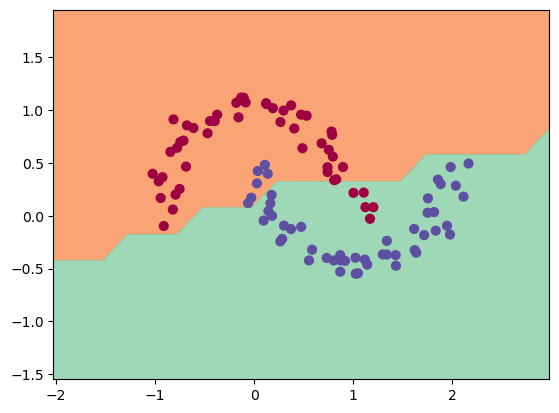

In [6]:
# visualize decision boundary
model = ShallowNet()
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
input_ = Tensor.fromlist(Xmesh.shape, data=Xmesh.flatten().tolist())

scores = snet(input_)

scores.realize()
Z = np.array([s > 0.5 for s in scores.data()])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
